In [7]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation,MaxPooling2D,Dropout
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping,LearningRateScheduler
from keras import regularizers
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras.regularizers import l2
import seaborn as sns
import os
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.2.0-rc3
Running on TPU  ['10.67.236.218:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.67.236.218:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.67.236.218:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [9]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
train_path = 'train'
valid_path = 'valid'
test_path  = 'test'
save_path = "."
train_gen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    channel_shift_range=10.,
    fill_mode="nearest"
)

train_batches = train_gen.flow_from_directory(directory=train_path, target_size=(224,224),
    classes=['dog', 'cat'], batch_size=32)
valid_batches = ImageDataGenerator().flow_from_directory(directory=valid_path, target_size=(224,224), 
    classes=['dog', 'cat'], batch_size=32)
test_batches = ImageDataGenerator().flow_from_directory(directory=test_path, target_size=(224,224),
    classes=['dog', 'cat'], batch_size=32,shuffle=False)


Found 10514 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [0]:
# learning rate schedule
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.5
	epochs_drop = 50.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

In [12]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(224,224,3),kernel_initializer='glorot_uniform',
           bias_initializer='zeros', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu',kernel_initializer='glorot_uniform', 
           bias_initializer='zeros', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu',kernel_initializer='glorot_uniform',
           bias_initializer='zeros', kernel_regularizer=l2(0.0005)),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu',kernel_initializer='glorot_uniform', 
           bias_initializer='zeros', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(2, activation='sigmoid')
    ])


model.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0001),metrics=['accuracy'])
#model.compile(loss='binary_crossentropy',optimizer=SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True),metrics=['accuracy'])

# Add all the call backs for Keras
reduce_lr_loss = ReduceLROnPlateau(
    monitor='val_loss', 
	factor=0.1, 
    patience=7, 
	verbose=1, 
    min_delta=1e-4,
	mode='auto')


mcp_save       = ModelCheckpoint(
    'cat_dog_kaggle.h5', 
	save_best_only=True, 
	monitor='val_loss', 
	mode='auto'
)


if os.path.isfile('cat_dog_kaggle.h5'):
        #This code is implemented to load the partly trained model which was stopped due to some reason
    print("Running the Partially Trained Model")
    partially_trained_model = load_model('cat_dog_kaggle.h5')
    history = partially_trained_model.fit_generator(generator=train_batches, initial_epoch=1,steps_per_epoch=len(train_batches), 
                              validation_data=valid_batches, validation_steps=len(valid_batches), 
                              epochs=150, callbacks=[mcp_save],verbose=1) 
else:
    print("Running the Training of Model from Scratch")
    history = model.fit_generator(generator=train_batches,initial_epoch=1,steps_per_epoch=len(train_batches), 
                              validation_data=valid_batches, validation_steps=len(valid_batches), 
                              epochs=150, callbacks=[ mcp_save],verbose=1)


model.save(os.path.join(save_path,"cat_dog_kaggle_final.h5"))


Running the Partially Trained Model
Epoch 2/150
329/329 [==============================] - 219s 665ms/step - loss: 1.1851 - accuracy: 0.6370 - val_loss: 0.5991 - val_accuracy: 0.6728
Epoch 3/150
329/329 [==============================] - 219s 667ms/step - loss: 0.9604 - accuracy: 0.6568 - val_loss: 0.8170 - val_accuracy: 0.6855
Epoch 4/150
329/329 [==============================] - 218s 663ms/step - loss: 0.8229 - accuracy: 0.6897 - val_loss: 1.0660 - val_accuracy: 0.7133
Epoch 5/150
329/329 [==============================] - 218s 662ms/step - loss: 0.7506 - accuracy: 0.7060 - val_loss: 0.4053 - val_accuracy: 0.7341
Epoch 6/150
329/329 [==============================] - 217s 659ms/step - loss: 0.6987 - accuracy: 0.7230 - val_loss: 0.6049 - val_accuracy: 0.7373
Epoch 7/150
329/329 [==============================] - 218s 663ms/step - loss: 0.6606 - accuracy: 0.7397 - val_loss: 0.3641 - val_accuracy: 0.7538
Epoch 8/150
329/329 [==============================] - 217s 661ms/step - loss: 0.6

In [5]:
!unzip dataset/train.zip 

Streaming output truncated to the last 5000 lines.
  inflating: train/dog/dog.1576.jpg  
  inflating: train/dog/dog.1577.jpg  
  inflating: train/dog/dog.1578.jpg  
  inflating: train/dog/dog.1579.jpg  
  inflating: train/dog/dog.158.jpg   
  inflating: train/dog/dog.1580.jpg  
  inflating: train/dog/dog.1581.jpg  
  inflating: train/dog/dog.1582.jpg  
  inflating: train/dog/dog.1583.jpg  
  inflating: train/dog/dog.1584.jpg  
  inflating: train/dog/dog.1585.jpg  
  inflating: train/dog/dog.1586.jpg  
  inflating: train/dog/dog.1587.jpg  
  inflating: train/dog/dog.1588.jpg  
  inflating: train/dog/dog.1589.jpg  
  inflating: train/dog/dog.159.jpg   
  inflating: train/dog/dog.1590.jpg  
  inflating: train/dog/dog.1591.jpg  
  inflating: train/dog/dog.1592.jpg  
  inflating: train/dog/dog.1593.jpg  
  inflating: train/dog/dog.1594.jpg  
  inflating: train/dog/dog.1595.jpg  
  inflating: train/dog/dog.1596.jpg  
  inflating: train/dog/dog.1597.jpg  
  inflating: train/dog/dog.1598.jpg  

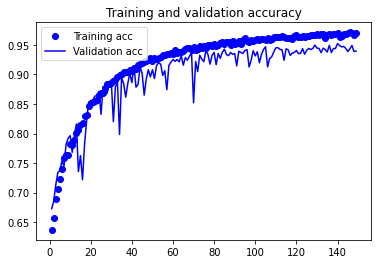

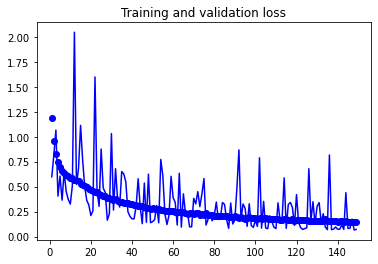

In [13]:
acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc') 
plt.title('Training and validation accuracy') 
plt.legend() 
plt.figure() 
plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss') 
plt.title('Training and validation loss') 
plt.savefig('accuracy.png')
plt.show()


In [0]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)/rows
    #cols = 8
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

#test_imgs, labels = next(test_batches)
#plots(test_batches, figsize=(100,80), rows=4)

In [7]:
predictions = model.predict_generator(generator=test_batches, steps=len(test_batches), verbose=0)
pred_label = np.argmax(predictions,axis=1)
classes = np.argmax(predictions, axis=1)
cm = confusion_matrix(test_batches.labels,pred_label)
f,ax = plt.subplots(figsize=(4, 4))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
plt.savefig('confusion_matrix.png')

NameError: ignored

In [0]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import metrics
tn, fp, fn, tp = cm.ravel()
accuracy = (tn + tp)/(tn + tp + fn +fp)
precision = precision_score(test_batches.labels, pred_label, average='binary')
recall = recall_score(test_batches.labels, pred_label,average='binary')
f1_score = f1_score(test_batches.labels, pred_label, average='binary')
score = metrics.accuracy_score(test_batches.labels, pred_label)
log_score = metrics.log_loss(pred_label, predictions)

In [0]:
print("Precision ",precision*100)
print("Recall ",recall*100)
print("F1 Score ",f1_score*100)
print("Accuracy of the model",accuracy*100)
print("Accuracy score: {}".format(score))
print("Log loss score: {}".format(log_score))

In [0]:
from sklearn.metrics import roc_curve, auc
def plot_roc(pred,y):
    fpr, tpr, _ = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()
plot_roc(pred_label,test_batches.labels)